In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.distributions as tdist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Set seed
torch.manual_seed(0)

# Where to add a new import
from torch.optim.lr_scheduler import StepLR

In [2]:
n_iters = 10000
n_sub_iters = 10
batch_size = 1 
num_atoms = 4

In [3]:
normal_dist = tdist.MultivariateNormal(torch.tensor([0.,0.]), torch.tensor([[1.,.5],[.5,1.]]))

In [4]:
def l2_cost(x,y):
    return torch.sqrt(torch.sum((x-y)**2, axis=1))

In [5]:
def er_chi_unnorm(x,yj,gj, epsilon, cost_func=l2_cost):
    return torch.exp((-cost_func(x,yj)+gj)/epsilon)

In [6]:
def er_chi(x, y, g, epsilon, cost_func=l2_cost):
    chis = er_chi_unnorm(x,y,g,epsilon, cost_func)
    return chis/ torch.sum(chis)

In [7]:
# entropic reg c-transform
def er_ctran(x, g, y, epsilon, cost_func):
    return -epsilon * torch.log(torch.sum(torch.exp((-cost_func(x,y)+g)/epsilon)/torch.tensor(num_atoms))) + torch.sum(g)/torch.tensor(num_atoms)

In [8]:
# init vectors
y = torch.tensor(4.*(-0.5+np.random.random(size=(num_atoms,2))), requires_grad = True)
g = torch.tensor(np.random.random(size=num_atoms), requires_grad = True)
b = torch.ones(num_atoms)/ torch.tensor(num_atoms)
epsilon = torch.tensor(2.)

In [10]:
y

tensor([[-0.6983,  1.9840],
        [-1.3672, -0.1577],
        [ 0.7330, -0.9106],
        [ 0.7656,  0.7969]], dtype=torch.float64, requires_grad=True)

In [14]:
y

tensor([[-0.6983,  1.9840],
        [-1.3672, -0.1577],
        [ 0.7330, -0.9106],
        [ 0.7656,  0.7969]], dtype=torch.float64, requires_grad=True)

## INSTANTIATE OPTIMIZER CLASS

In [11]:
learning_rate = 0.1
optimizer_atoms = torch.optim.SGD([y], lr=learning_rate, momentum=0.9, nesterov=True)
optimizer_map = torch.optim.SGD([g], lr=learning_rate, momentum=0.9, nesterov=True)

## INSTANTIATE STEP LEARNING SCHEDULER CLASS

In [12]:
# step_size: at how many multiples of epoch you decay
# new_lr = lr*gamma 

# gamma = decaying factor
scheduler_atoms = StepLR(optimizer_atoms, step_size=1, gamma=0.1)
scheduler_map = StepLR(optimizer_map, step_size=1, gamma=0.1)



# TRAIN TRANSPORT MAP

In [13]:
for i in range(n_iters):
    x = normal_dist.sample()

    # Clear gradients w.r.t. parameters
    optimizer_map.zero_grad()

    # Get dual objective to maximise
    dual_objective = er_ctran(x, g, y, epsilon, l2_cost)
    map_loss = -dual_objective

    # Getting gradients w.r.t. parameters
    map_loss.backward()
    optimizer_map.step()
    
    # Updating parameters
    if i % 250 == 0:
        scheduler_map.step()
        

# PLOT OUTPUT

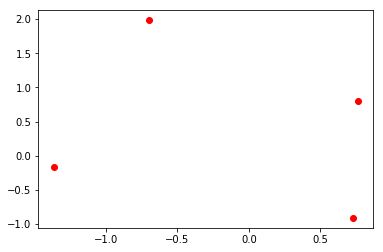

In [15]:
# Plot y atoms
ys = y.detach().numpy()
plt.plot(ys[:,0],ys[:,1], 'ro')

In [ ]:
plot_ys = []
plot_xs = []
chis = []
num_points = 1000

for _ in range(num_points):
    x = normal_dist.sample()
    chis.append(er_chi(x, y, g, epsilon).detach().numpy())
    plot_xs.append(x.numpy())
    
ys = y.detach().numpy()
plot_xs = np.array(plot_xs)
chis = np.array(chis)
allocations = np.argmax(chis, axis=1)

In [16]:
colors = cm.rainbow(np.linspace(0, 1, num_atoms))
for atom_idx in range(num_atoms):
    view = allocations==atom_idx
    plt.scatter(plot_xs[view,0], plot_xs[view,1], color=colors[atom_idx])
    plt.plot(ys[atom_idx,0],ys[atom_idx,1], 'rx')
plt.show()

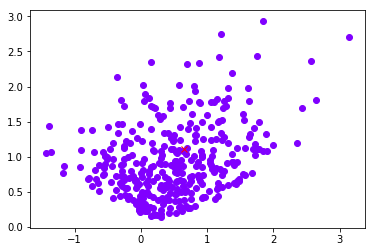

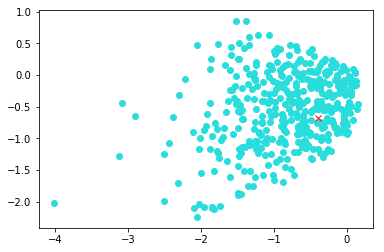

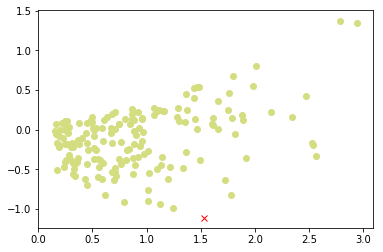

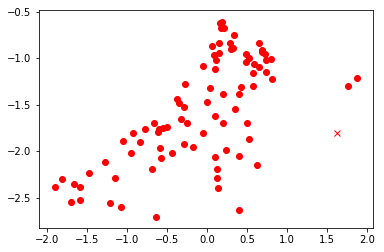

In [189]:
colors = cm.rainbow(np.linspace(0, 1, num_atoms))
for atom_idx in range(num_atoms):
    view = allocations==atom_idx
    plt.scatter(plot_xs[view,0], plot_xs[view,1], color=colors[atom_idx])
    plt.plot(ys[atom_idx,0],ys[atom_idx,1], 'rx')
    plt.show()

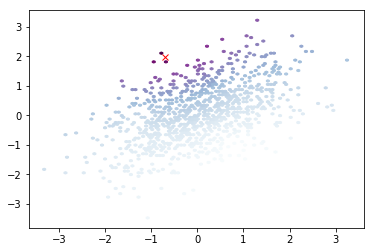

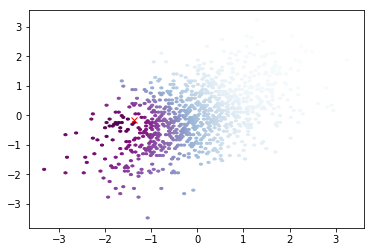

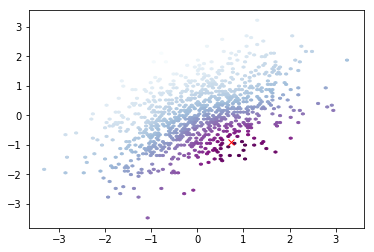

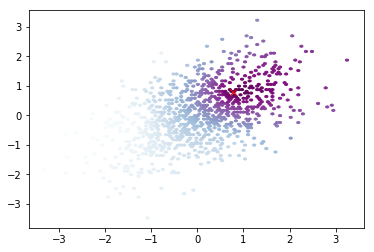

In [18]:
for j in range(num_atoms):
    plt.plot(ys[j,0],ys[j,1], 'rx')
    plt.hexbin(plot_xs[:,0], plot_xs[:,1], chis[:,j], cmap=plt.cm.BuPu)
    plt.show()

##  RE-INIT and TRAIN MODEL

In [92]:
n_iters = 1000
n_sub_iters = 10
multiplier = 5
num_atoms = 20
dim = 2

# init vectors
y = torch.tensor(2*(-0.5+np.random.random(size=(num_atoms,dim))), requires_grad = False)
g = torch.tensor(np.random.random(size=num_atoms), requires_grad = True)
b = torch.ones(num_atoms)/ torch.tensor(num_atoms)
epsilon = torch.tensor(2.)

# optimizers
learning_rate = 0.1
optimizer_atoms = torch.optim.SGD([y], lr=learning_rate, momentum=0.9, nesterov=True)
optimizer_map = torch.optim.SGD([g], lr=learning_rate, momentum=0.9, nesterov=True)

scheduler_atoms = StepLR(optimizer_atoms, step_size=1, gamma=0.8)
scheduler_map = StepLR(optimizer_map, step_size=1, gamma=0.8)


### Min Max Optimization

In [102]:
for i in range(n_iters):
    for _ in range(n_sub_iters):
        # sample x
        x = normal_dist.sample()

        # Clear gradients w.r.t. parameters
        optimizer_map.zero_grad()
        
        # Get dual objective to maximise
        dual_objective = er_ctran(x, g, y, epsilon, l2_cost)
        map_loss = -dual_objective
        
        # Getting gradients w.r.t. parameters
        map_loss.backward()

        # Updating parameters
        optimizer_map.step()
        
    for _ in range(multiplier*n_sub_iters):
        # sample x
        x = normal_dist.sample()

        # Clear gradients w.r.t. parameters
        optimizer_atoms.zero_grad()
        
        # Get loss objective to minimise
        atoms_loss = er_ctran(x, g, y, epsilon, l2_cost)
        
        # Getting gradients w.r.t. parameters
        atoms_loss.backward()

        # Updating parameters
        optimizer_atoms.step()
    
    # Updating parameters
    if i % 100 == 0:
        print(g)
        print(map_loss)
        # Decay Learning Rate
        scheduler_atoms.step()
        scheduler_map.step()
        
        print("Iteration: {0} \n".format(i))
        print("Loss: {0}".format(map_loss))
        

tensor([0.6239, 0.5160, 0.3767, 0.5395, 0.4287, 0.5797, 0.5361, 0.4969, 0.5258,
        0.4758, 0.5867, 0.4009, 0.7013, 0.7049, 0.5159, 0.6289, 0.4123, 0.3887,
        0.4785, 0.8897], dtype=torch.float64, requires_grad=True)
tensor(-0.8409, dtype=torch.float64, grad_fn=<NegBackward>)
Iteration: 0 

Loss: -0.8409205156398452
tensor([0.6239, 0.5160, 0.3767, 0.5395, 0.4287, 0.5797, 0.5361, 0.4969, 0.5258,
        0.4758, 0.5867, 0.4009, 0.7013, 0.7049, 0.5159, 0.6289, 0.4123, 0.3887,
        0.4785, 0.8897], dtype=torch.float64, requires_grad=True)
tensor(-1.0178, dtype=torch.float64, grad_fn=<NegBackward>)
Iteration: 100 

Loss: -1.0177676651840208
tensor([0.6239, 0.5160, 0.3767, 0.5395, 0.4288, 0.5797, 0.5361, 0.4969, 0.5258,
        0.4758, 0.5867, 0.4009, 0.7013, 0.7049, 0.5159, 0.6289, 0.4123, 0.3887,
        0.4785, 0.8897], dtype=torch.float64, requires_grad=True)
tensor(-1.1091, dtype=torch.float64, grad_fn=<NegBackward>)
Iteration: 200 

Loss: -1.1090968227849674
tensor([0.6239,

In [82]:
g

tensor([0.7683, 0.6396], dtype=torch.float64, requires_grad=True)

In [83]:
y

tensor([[ 0.0311, -0.7011],
        [-0.3348,  0.2281]], dtype=torch.float64)

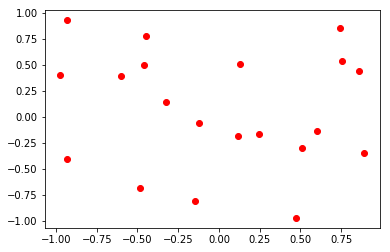

In [103]:
# Plot y atoms
ys = y.detach().numpy()
plt.plot(ys[:,0],ys[:,1], 'ro')

((array([3., 0., 4., 1., 2., 2., 1., 2., 1., 4.]),
  array([-0.97523861, -0.78835974, -0.60148087, -0.41460201, -0.22772314,
         -0.04084427,  0.1460346 ,  0.33291347,  0.51979234,  0.70667121,
          0.89355007]),
  <a list of 10 Patch objects>),
 (array([2., 1., 1., 2., 4., 1., 0., 6., 0., 3.]),
  array([-0.97247257, -0.78265408, -0.59283559, -0.40301711, -0.21319862,
         -0.02338013,  0.16643836,  0.35625685,  0.54607534,  0.73589382,
          0.92571231]),
  <a list of 10 Patch objects>))

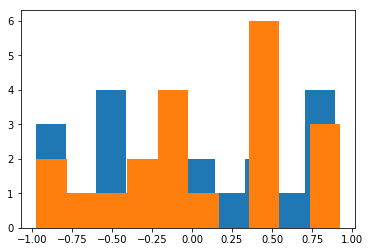

In [104]:
plt.hist(ys[:,0]), plt.hist(ys[:,1])

In [105]:
plot_ys = []
plot_xs = []
chis = []
num_points = 1000

for _ in range(num_points):
    x = normal_dist.sample()
    chis.append(er_chi(x, y, g, epsilon).detach().numpy())
    plot_xs.append(x.numpy())
    
ys = y.detach().numpy()
plot_xs = np.array(plot_xs)
chis = np.array(chis)
allocations = np.argmax(chis, axis=1)

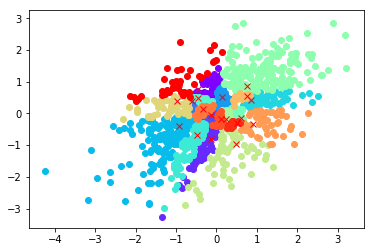

In [106]:
colors = cm.rainbow(np.linspace(0, 1, num_atoms))
for atom_idx in range(num_atoms):
    view = allocations==atom_idx
    plt.scatter(plot_xs[view,0], plot_xs[view,1], color=colors[atom_idx])
    plt.plot(ys[atom_idx,0],ys[atom_idx,1], 'rx')
plt.show()

In [79]:
y

tensor([[0.9428, 0.8862],
        [0.5623, 0.4084]], dtype=torch.float64)